### Kaggle - Quora Question Pairs

The goal of this competition is to predict whether two sentences share the same intent. This would be useful for Quora so that they could determine if a question has already been asked, and if so, provide the answer.

In this notebook, we will do some quick data exploration and build a couple of simple models

First, lets import useful libraries and load our data

In [9]:
import numpy as np # arrays and matrices
import pandas as pd # convienient data access, I/O
import matplotlib.pyplot as plt # plotting

%matplotlib inline
pd.set_option('display.max_colwidth', -1) # prevents pandas from truncating text when displaying dataframe
pd.set_option('display.max_columns', None) # prevents pandas from not displaying all columns

train = pd.read_csv('train.csv').fillna('')
test = pd.read_csv('test.csv').fillna('')

print("Training data size, {}".format(train.shape))
print("Testing data size, {}".format(test.shape))

Training data size, (404290, 6)
Testing data size, (2345796, 3)


In [10]:
train.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
145441,145441,229966,63171,Which are your two favorite podcasts?,What are some best podcasts?,1
75546,75546,129278,46045,Who view my instagram video?,How do I see who viewed my Instagram video?,1
351253,351253,117249,389298,How do I cure myopia naturally?,Can myopia be cured?,0
10599,10599,20518,20519,Does drinking pure lemon juice burn fat?,Does drinking lemon juice in the morning on an empty stomach help in reducing belly fat?,0
366590,366590,88661,496812,Can I request an Uber online or do I need the app?,How do you download the Uber app?,0


In [11]:
test.sample(3)

,test_id,question1,question2
1260834,1260834,Which language is easier to roosevelt learn for a Kannadiga: Hindi or Tamil?,Which language available easier to learn for a Telugu person: Hindi or Tamil?
571976,571976,What making volatile liquids? What are some examples?,How does of gas to liquid?
931554,931554,Are there any and dynamic Call in Cobol,What is the difference created static and dynamic binding?


In [12]:
train.is_duplicate.mean()

0.36919785302629299

#### NLP Crash course

A simple approach to comparing the similarity between two sentences involves the following steps

1. Tokenization: splitting each sentence into a sequence of words
  * "How do I learn to ask the right questions?" --> ["how", "do", "I", "learn", "to", "ask", "the", "right", "questions", "?"]
2. Word vectorization: unique words will serve as a basis for a vector space
  * "How" --> [0, 0, ..., 1, 0, 0, 0, ...]
3. Sentence vectorization: word vectors are combined so that a sentence has a vector representation
  * Simple method is to add all the word vectors that occur in a sentence
4. Similarity measurement: function that will take as input two sentence vectors, and output a single number representing their similarity
  * Cosine similarity/distance has been shown to perform well on these sparse vectors
  
Let's grab a small peice of data and quickly demonstrate these steps

(Note to self during presentation: run the next few code blocks now! - if I don't do this, remind me :) )


In [13]:
# nltk is a well used library for NLP in python
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display

# one small improvement we can make before we start, is to have a set of common words that we know 
# don't carry very much information - we can tell the vectorizer to ignore these words
sw = set(stopwords.words('english'))
print("Vectorizer will ignore these words: \n{}".format(sw))

sample_df = train.sample(2)
display(sample_df)

sample_qs = sample_df.question1.tolist() + sample_df.question2.tolist()

count_vect = CountVectorizer(binary=True, tokenizer=word_tokenize, stop_words=sw)
vectorizer = count_vect.fit(sample_qs) # show our count vectorizer our full vocabulary

# map each column of questions into our learned vector space
ques1_matrix = vectorizer.transform(sample_df.question1.tolist())
ques2_matrix = vectorizer.transform(sample_df.question2.tolist())

vocab = [word[0] for word in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[0])] 
display(pd.DataFrame(ques1_matrix.toarray(), columns=vocab))
display(pd.DataFrame(ques2_matrix.toarray(), columns=vocab))
print("Number of unique words: {}".format(len(vocab)))

Vectorizer will ignore these words: 
{'below', 'not', 'weren', 'himself', 'they', 'this', 'between', 'their', 'am', 'the', 'ourselves', 'with', 'being', 'his', 'other', 'over', 've', 'further', 'having', 'but', 'won', 'them', 'didn', 'd', 'off', 'for', 'themselves', 'll', 'some', 'when', 'aren', 'because', 'shouldn', 'or', 'up', 'all', 'very', 'have', 'out', 'itself', 'i', 'who', 'where', 'own', 'do', 'haven', 'herself', 'yourself', 'during', 'again', 'to', 'just', 'more', 'our', 'on', 'are', 's', 'should', 'at', 'be', 'has', 'these', 't', 'he', 'its', 'against', 'that', 'you', 'by', 'few', 'whom', 'an', 'theirs', 'couldn', 'were', 'doesn', 'her', 'a', 'why', 'she', 'which', 'ours', 'me', 'most', 'needn', 'myself', 'if', 'what', 'down', 'from', 'we', 'had', 'will', 'both', 'of', 'so', 'mustn', 'then', 'until', 'how', 'too', 'can', 'as', 'each', 'shan', 'only', 'your', 'those', 'now', 'him', 'about', 'than', 'once', 'my', 'hasn', 'nor', 'above', 'was', 'isn', 'been', 'into', 'm', 'ain',

,id,qid1,qid2,question1,question2,is_duplicate
286729,286729,407365,407366,Why did people vote for Narendra Modi?,Why do some people hate Narendra Modi?,0
134162,134162,214486,214487,Do sociopaths know they are sociopaths or recognize other sociopaths?,Do sociopaths recognize other sociopaths?,1


,?,hate,know,modi,narendra,people,recognize,sociopaths,vote
0,1,0,0,1,1,1,0,0,1
1,1,0,1,0,0,0,1,1,0


,?,hate,know,modi,narendra,people,recognize,sociopaths,vote
0,1,1,0,1,1,1,0,0,0
1,1,0,0,0,0,0,1,1,0


Number of unique words: 9


In [14]:
from sklearn.metrics.pairwise import paired_cosine_distances

distance = paired_cosine_distances(ques1_matrix, ques2_matrix)
sample_df['sim'] = 1 - distance
display(sample_df)

,id,qid1,qid2,question1,question2,is_duplicate,sim
286729,286729,407365,407366,Why did people vote for Narendra Modi?,Why do some people hate Narendra Modi?,0,0.800000
134162,134162,214486,214487,Do sociopaths know they are sociopaths or recognize other sociopaths?,Do sociopaths recognize other sociopaths?,1,0.866025


In [15]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


Lets, apply this method to the full data and visualize how well it can discriminate duplicate questions

Also, for presentation, go run the next couple code blocks again!

In [16]:
all_qs = train.question1.tolist() + train.question2.tolist()
vectorizer = count_vect.fit(all_qs)
print("Size of our vocabulary: {}".format(len(vectorizer.vocabulary_)))

ques1_matrix = vectorizer.transform(train.question1.tolist())
ques2_matrix = vectorizer.transform(train.question2.tolist())

train['sim'] = 1 - paired_cosine_distances(ques1_matrix, ques2_matrix)
display(train.sample(5))

Size of our vocabulary: 113428


,id,qid1,qid2,question1,question2,is_duplicate,sim
382233,382233,30057,21380,How QuickBooks Proavisor Tech support Phone Number is Prominent for getting Solutions?,What is the best QuickBooks support number in Arkansas?,1,0.516398
60399,60399,105626,105627,What is the significant difference between hard water and soft water? What are their uses?,What is the difference between hard and soft water?,1,0.845154
386176,386176,29048,518353,Why China helping Pakistan?,Why is China helping Pakistan?,1,1.000000
23185,23185,43464,43465,I have scored 410 marks in NEET 2016. Which private colleges should I apply for?,I have scored 316 marks in NEET 2016. Which private colleges should I apply for?,0,0.888889
323142,323142,449071,449072,What are movies or TV series similar to Jonny Quest?,What are some good movies or TV series similar to Jonny Quest?,1,0.935414


In [17]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(train.is_duplicate.values, train.sim.values)
print("Predictive power of this similarity metric:\nAUC score = {}".format(auc))

Predictive power of this similarity metric:
AUC score = 0.7490473639690706


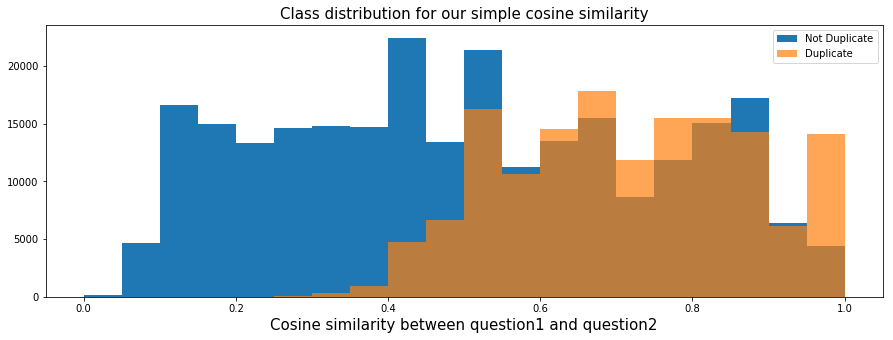

In [18]:
plt.figure(figsize=(15, 5))
plt.hist(train.loc[train.is_duplicate == 0, 'sim'].tolist(), 
         bins=np.arange(0, 1.05, 0.05), label='Not Duplicate')
plt.hist(train.loc[train.is_duplicate == 1, 'sim'].tolist(), 
         bins=np.arange(0, 1.05, 0.05), alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Class distribution for our simple cosine similarity', fontsize=15)
plt.xlabel('Cosine similarity between question1 and question2', fontsize=15)
plt.show()

For such a simple model, it does a great job discriminating some question pairs that do not have the same intent. However it does a poor job when the two sentences have a few words that overlap.

This method has some blatant weaknesses:
1. Even after removing stopwords, there are words that are very common that have low discriminatory power.
2. Syntactic stucture is lost
  * "Do not worry, the fire is under control" vs. "Do worry, the fire is not under control"
3. Semantic relationship between words is lost
  * "Right" vs. "Correct" vs. "Wrong" - all equally distant from each other
  
There are several approaches that can be used to try to overcome this:
1. Reweighting each words magnitude in the vector space to better represent it's discriminatory power.
  * TF-IDF - unsupervised method of reweighting based on two assumptions
    * TF - a function that determines what to do when a word appears more than once in a document
    * IDF - discriminatory power of a word is inversely proportional to the number of different documents it appears in
  * TF-KLD - a supervised algorithm that learns how important it is for a word to appear in both sentences, given that it appears in either
2. Expand the sentence representation to include pairs of words (bigrams), triples (trigrams), etc.
  * "Do not worry" --> ["do", "not", "worry", "do_not", "not_worry", "do_not_worry"]
    * This drastically increases the size of the vocabulary, so it is common to only use n-grams that appear more than x times
3. Stemming / lemmatization and including synonyms
  * stemming : "cats", "catlike", "catty" --> "cat"
  * lemmatization : "am", "are", "is" --> "be"

### TF-KLD

Involves looking at two probabilities for each word, k:
1. $p_{k}$ = Probability that the first sentence contains k, given that k appears in the other sentence and the two sentences are paraphrases
2. $q_{k}$ = Probability that the first sentence contains k, given that k appears in the other sentence and the two sentences are not paraphrases

Then, for each word, the Kullback-Leibler divergence:
$$KL(p_{k}||q_{k}) = \sum_{x} p_{k}(x)\log{\frac{p_{k}(x)}{q_{k}(x)}}$$
is a measure of its discriminability and is gauranteed to be nonnegative

If $p_{k} \approx q_{k}$ then $KL(k) \approx 0$

In [19]:
from parrot.tfkld_vectorizer import TfkldCountVectorizer

tfkld_vect = TfkldCountVectorizer(binary=True, tokenizer=word_tokenize, 
                                  stop_words=None)
ques1_matrix, ques2_matrix = tfkld_vect.fit_transform(labels=train.is_duplicate.tolist(), 
                                                     doc1=train.question1.tolist(),
                                                     doc2=train.question2.tolist(), 
                                                     verbose=True)

Calculating kld word significance
Calculating kld word probabilities
length of vocab: 113578
length of kld_weights: 113578


In [20]:
train['kld_sim'] = 1 - paired_cosine_distances(ques1_matrix, ques2_matrix)

auc = roc_auc_score(train.is_duplicate.values, train.kld_sim.values)
print("Predictive power of this similarity metric:\nAUC score = {}".format(auc))

Predictive power of this similarity metric:
AUC score = 0.8297224179206729


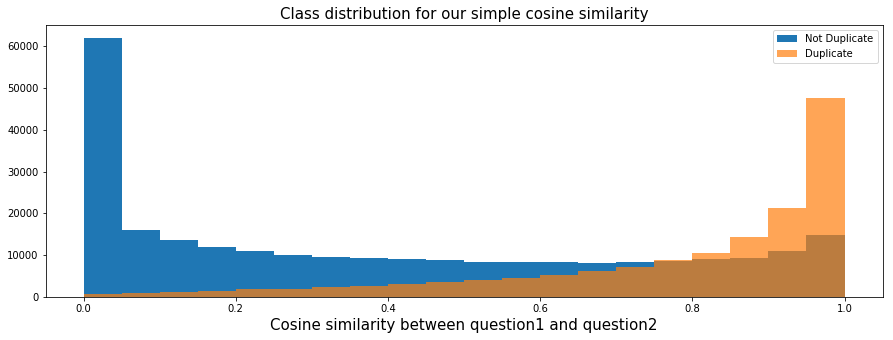

In [21]:
plt.figure(figsize=(15, 5))
plt.hist(train.loc[train.is_duplicate == 0, 'kld_sim'].tolist(), 
         bins=np.arange(0, 1.05, 0.05), label='Not Duplicate')
plt.hist(train.loc[train.is_duplicate == 1, 'kld_sim'].tolist(), 
         bins=np.arange(0, 1.05, 0.05), alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Class distribution for our simple cosine similarity', fontsize=15)
plt.xlabel('Cosine similarity between question1 and question2', fontsize=15)
plt.show()

In [22]:
kld_weights = tfkld_vect.kld_weights

def print_kld_weight(word):
    try:
        print("{}: {}".format(word, kld_weights[word]))
    except:
        print("{} does not appear in training".format(word))
print("these words should all recieve lower weights:")
print_kld_weight("the")
print_kld_weight("are")
print_kld_weight("is")

print("\nthese words should recieve higher weights:")
print_kld_weight("volcano")
print_kld_weight("chicken")
print_kld_weight("data")

these words should all recieve lower weights:
the: 0.013429759203404404
are: 0.020423674077738332
is: 0.013735694426115677

these words should recieve higher weights:
volcano: 0.29296113512249244
chicken: 0.22204563513986622
data: 0.2260378649881151


In [27]:
from xgboost import XGBClassifier as xgb

from sklearn.model_selection import train_test_split

features = train.loc[:, ['sim', 'kld_sim']].values
labels = train.is_duplicate.values

X_train, X_val, y_train, y_val = train_test_split(features, labels, 
                                                  test_size=0.10, random_state=0)

# dtrain = xgb.DMatrix(X_train, y_train)
# dval = xgb.DMatrix(X_val, y_val)

param = {}
param['max_depth'] = 2
param['learning_rate'] = 0.2
param['objective'] = 'binary:logistic'
param['nthread'] = -1
param['n_estimators'] = 100
# param['num_class'] = len(data.label.unique())

model = xgb(**param)
eval_set = [(X_train, y_train), (X_val, y_val)]

model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, 
          early_stopping_rounds=10, verbose=True)

[0]	validation_0-error:0.256139	validation_0-logloss:0.630702	validation_1-error:0.256944	validation_1-logloss:0.631045
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.249527	validation_0-logloss:0.588679	validation_1-error:0.250538	validation_1-logloss:0.589139
[2]	validation_0-error:0.249527	validation_0-logloss:0.559352	validation_1-error:0.250538	validation_1-logloss:0.559804
[3]	validation_0-error:0.248971	validation_0-logloss:0.537902	validation_1-error:0.250019	validation_1-logloss:0.538099
[4]	validation_0-error:0.245228	validation_0-logloss:0.520917	validation_1-error:0.246383	validation_1-logloss:0.521144
[5]	validation_0-error:0.244316	validation_0-logloss:0.508505	validation_1-error:0.245789	validation_1-logloss:0.5088
[6]	validation_0-error:0.242285	validation_0-logloss:0.498465	validation_1-error:0.244057	validation_1-logloss:0.4987

[67]	validation_0-error:0.232297	validation_0-logloss:0.447031	validation_1-error:0.233966	validation_1-logloss:0.446911
[68]	validation_0-error:0.232009	validation_0-logloss:0.446855	validation_1-error:0.233966	validation_1-logloss:0.446753
[69]	validation_0-error:0.232025	validation_0-logloss:0.446838	validation_1-error:0.233867	validation_1-logloss:0.446729
[70]	validation_0-error:0.232025	validation_0-logloss:0.446821	validation_1-error:0.233867	validation_1-logloss:0.446713
[71]	validation_0-error:0.232061	validation_0-logloss:0.446784	validation_1-error:0.234065	validation_1-logloss:0.446672
[72]	validation_0-error:0.231874	validation_0-logloss:0.446736	validation_1-error:0.233941	validation_1-logloss:0.446643
[73]	validation_0-error:0.231872	validation_0-logloss:0.446722	validation_1-error:0.233842	validation_1-logloss:0.446621
[74]	validation_0-error:0.231872	validation_0-logloss:0.446699	validation_1-error:0.233842	validation_1-logloss:0.446589
[75]	validation_0-error:0.231786

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

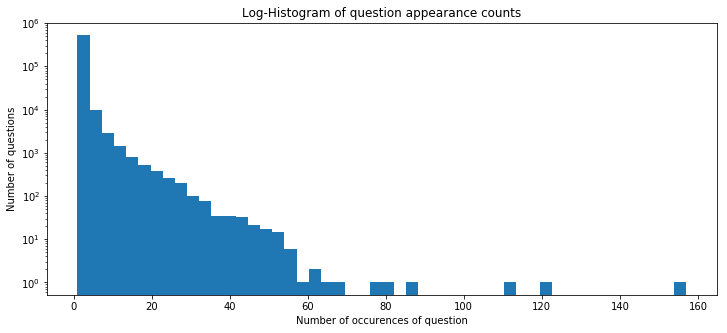

In [28]:
qids = pd.Series(train.qid1.tolist() + train.qid2.tolist())
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

In [29]:
qids.value_counts()[0:5]

2559     157
30782    120
4044     111
2561     88 
14376    79 
dtype: int64

In [30]:
train.loc[train.qid1==2559]

,id,qid1,qid2,question1,question2,is_duplicate,sim,kld_sim
14712,14712,2559,4506,What are the best ways to lose weight?,What would be a realistic plan to lose weight?,1,0.547723,9.594937e-01
38200,38200,2559,2711,What are the best ways to lose weight?,What is the best method of losing weight?,1,0.600000,6.295275e-01
56239,56239,2559,10321,What are the best ways to lose weight?,Where do I find a simple to understand solution on how to lose weight?,1,0.507093,8.578867e-01
81363,81363,2559,43605,What are the best ways to lose weight?,I'm overweight. How can I begin to lose weight?,1,0.507093,9.385209e-01
81973,81973,2559,23803,What are the best ways to lose weight?,What is the fastest possible way to lose weight?,1,0.547723,9.513431e-01
82016,82016,2559,7445,What are the best ways to lose weight?,What should I do to reduce weight?,1,0.516398,6.807545e-01
86631,86631,2559,5358,What are the best ways to lose weight?,What's the best plan to lose weight?,1,0.730297,9.970770e-01
89295,89295,2559,17100,What are the best ways to lose weight?,"I am ugly and fat, how to lose weight?",1,0.547723,9.282231e-01
106632,106632,2559,10322,What are the best ways to lose weight?,How can I lose 4kg weight?,1,0.670820,5.323794e-01
113625,113625,2559,2712,What are the best ways to lose weight?,What are the best way of loose the weight?,1,0.600000,7.361295e-01
